In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2024-01-11 21:16:59.364213: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 21:16:59.385011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 21:16:59.385031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 21:16:59.385553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 21:16:59.389239: I tensorflow/core/platform/cpu_feature_guar

In [2]:
x = pd.read_csv("Cary_Weather_Data.csv")
x['DATE'] = pd.to_datetime(x['YEAR'].astype(str) + '-' + x['MONTH'].astype(str) + '-' + x['DAY'].astype(str), yearfirst=True)
x = x.drop(columns=['YEAR','MONTH','DAY'])
#x = x.drop(columns=['Humidity','Precipitation','Wind Speed'])
#x.set_index('DATE', inplace=True)
x.describe().transpose()


,count,mean,min,25%,50%,75%,max,std
Temperature,15531.0,11.968674,1.23,9.7,12.06,14.37,24.41,3.399636
Humidity,15531.0,8.940999,0.67,4.88,8.61,12.82,19.29,4.513132
Precipitation,15531.0,3.241177,0.0,0.0,0.24,3.095,168.52,7.123667
Wind Speed,15531.0,1.942345,0.28,1.36,1.77,2.31,8.81,0.858653
DATE,15531,2002-10-04 00:00:00.000000128,1981-07-01 00:00:00,1992-02-16 12:00:00,2002-10-04 00:00:00,2013-05-21 12:00:00,2024-01-07 00:00:00,NaN


In [3]:
trainDF = x[:12426]
validDF =  x[:12426]
num_features = x.shape[1]
num_features

5

In [4]:
train_mean = trainDF.mean()
train_STD = trainDF.std()

trainDF = (trainDF - train_mean) / train_STD
validDF = (validDF - train_mean) / train_STD

/tmp/ipykernel_24708/29831655.py:4: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  trainDF = (trainDF - train_mean) / train_STD
/tmp/ipykernel_24708/29831655.py:5: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  validDF = (validDF - train_mean) / train_STD


/tmp/ipykernel_24708/669509490.py:1: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_std = (x - train_mean) / train_STD
/tmp/ipykernel_24708/669509490.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(x.keys(), rotation=90)


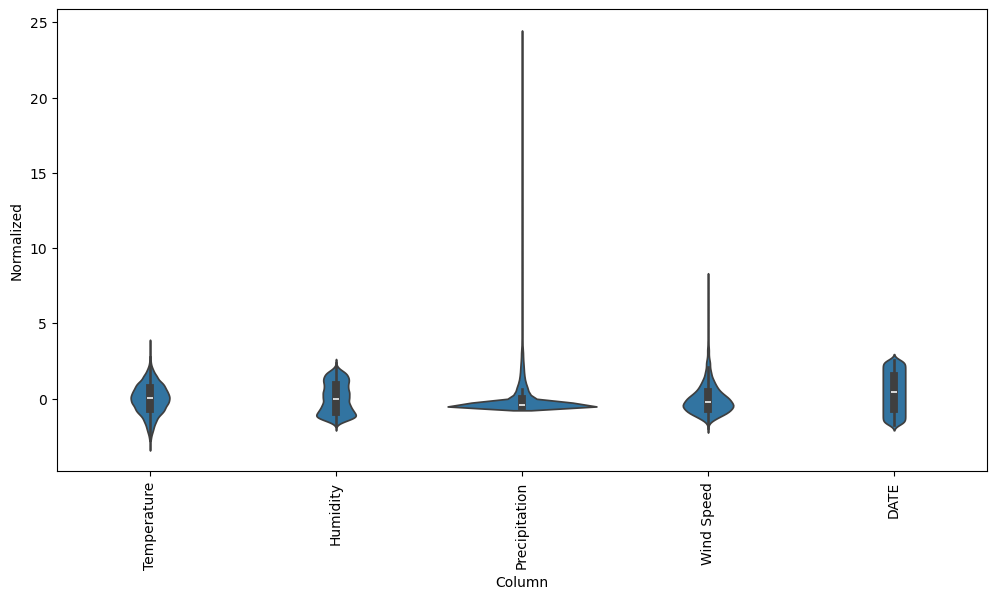

In [5]:
df_std = (x - train_mean) / train_STD
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(x.keys(), rotation=90)


In [6]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, trainDF=trainDF, validDF=validDF, label_columns=None):
        
        #Store raw data
        self.trainDF = trainDF
        
        self.validDF = validDF
        
        #Figure our label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: 1 for i, name in enumerate(trainDF.columns)}
        
        # Figure out window pameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[: self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns])
        # slicing doesn't preserve static shape info
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
    
        return inputs, labels
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(data=data, targets=None, sequence_length=self.total_window_size, sequence_stride=1, batch_size=32)
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column(s): {self.label_columns}'])
#print(trainDF.head())

In [7]:
#def split_window(self, features):
    #inputs = features[:, self.input_slice, :]
    #labels = features[: self.labels_slice, :]
    #if self.label_columns is not None:
        #labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns])
    # slicing doesn't preserve static shape info
    #inputs.set_shape([None, self.input_width, None])
    #labels.set_shape([None, self.label_width, None])
    
    #return inputs, labels

#WindowGenerator.split_window = split_window

In [8]:
#def make_dataset(self, data):
    #data = np.array(data, dtype=np.float32)
    #ds = tf.keras.utils.timeseries_dataset_from_array(data=data, targets=None, sequence_length=self.total_window_size, sequence_stride=1, batch_size=32)
#WindowGenerator.make_dataset = make_dataset

In [9]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=['Temperature']
)

In [10]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Precipitation'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column(s): ['Precipitation']

In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[5, 32]))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, 'linear'))

cp = tf.keras.callbacks.ModelCheckpoint('model', save_best_only=True)
#model.compile(loss='mse', optimizer='adam', metrics=['rmse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25361 (99.07 KB)
Trainable params: 25361 (99.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-01-11 21:17:01.004689: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 21:17:01.027688: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 21:17:01.032766: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [14]:
MAX_EPOCHS = 1

def compile_and_fit(model, window, patience=2): 
  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    #patience=patience,
                                                    #mode='min')
  history = None
  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
  
  train = window.split_window(window.trainDF)
  valid = window.split_window(window.validDF)

  
  train = window.make_dataset(window.trainDF)
  valid = window.make_dataset(window.validDF)

  #if (window.trainDF.empty() or window.validDF.empty() == False):
  history = model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=valid,
                      callbacks=[cp])
  return history

In [15]:
#single_step_window.trainDF.head()
#single_step_window.validDF.head()
#if ( (not single_step_window.trainDF.empty()) and (not single_step_window.validDF.empty())):
single_step_window.validDF.any()
history = compile_and_fit(model, single_step_window)


InvalidIndexError: (slice(None, None, None), slice(0, 1, None), slice(None, None, None))

In [ ]:
#trainX = []
#trainY = []
#n_future = 1
#n_past = 30

In [ ]:
#def df_to_X_y(df, window_size=5):
  #df_as_np = df.to_numpy()
  #X = []
  #y = []
  #for i in range(len(df_as_np)-window_size):
    #row = [[a] for a in df_as_np[i:i+window_size]]
    #X.append(row)
    #label = df_as_np[i+window_size]
    #y.append(label)
  #return np.array(X), np.array(y)

In [ ]:
#WINDOW_SIZE = 5
#X, y = df_to_X_y(x, WINDOW_SIZE)
#X.shape, y.shape

In [ ]:
#X_train, y_train = X[:12426], y[:12426]
#X_val, y_val = X[12426:], y[12426:]

In [ ]:
#for i in range(n_past, len(train_data) - n_future + 1):
    #trainX.append(train_data[i - n_past:i, 0:train_data.shape[1]])
    #trainY.append(train_data[i + n_future - 1:i +n_future, 0])
#trainX, trainY = np.array(trainX), np.array(trainY)


#train_set = tf.data.Dataset.from_tensor_slices((trainX, trainY))
#train_set = train_set.batch(128)
#trainX.shape, trainY.shape

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[5, 32]))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, 'linear'))

cp = tf.keras.callbacks.ModelCheckpoint('model', save_best_only=True)
model.compile(loss='mse', optimizer='adam', metrics=['rmse'])
model.summary()

X_train = tf.squeeze(X_train)
X_train = tf.transpose(X_train)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                24832     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25361 (99.07 KB)
Trainable params: 25361 (99.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tf.config.run_functions_eagerly(True)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=cp)

ValueError: Data cardinality is ambiguous:
  x sizes: 5
  y sizes: 12426
Make sure all arrays contain the same number of samples.

KeyError: 'val_loss'

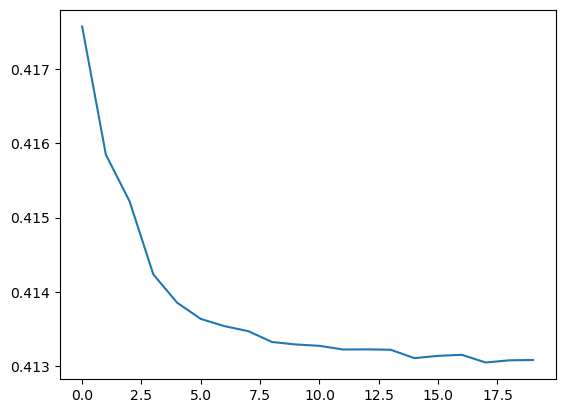

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/97 [===>..........................] - ETA: 0s

/home/kb/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


97/97 [==============================] - 1s 7ms/step


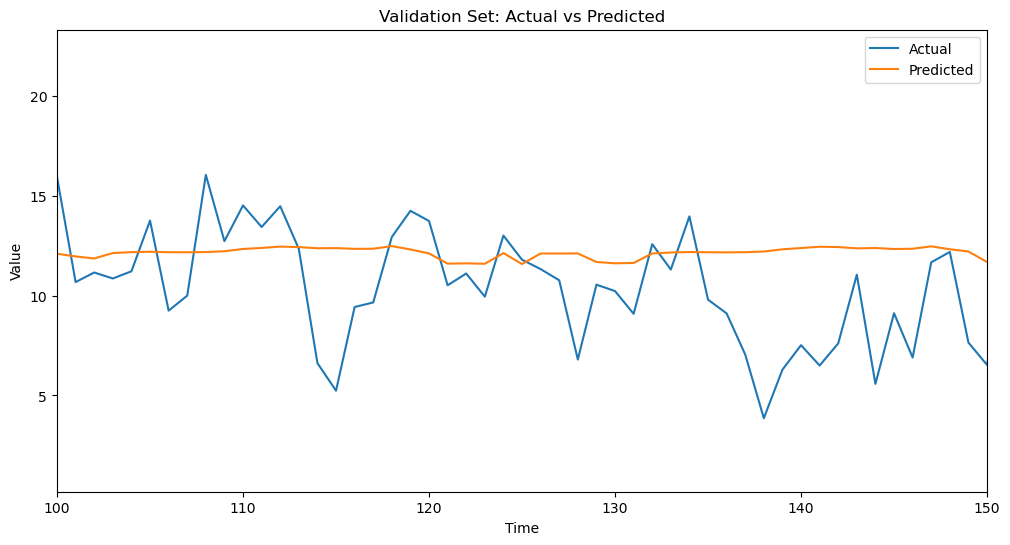

In [ ]:
# ... (previous code)

# Making predictions on the validation split
validX = []
validY = []
for i in range(n_past, len(valid_data) - n_future + 1):
    validX.append(valid_data[i - n_past:i, 0:valid_data.shape[1]])
    validY.append(valid_data[i + n_future - 1:i + n_future, 0])
validX, validY = np.array(validX), np.array(validY)

# Reshape data for prediction
validX = validX.reshape((validX.shape[0], n_past, valid_data.shape[1]))

# Make predictions
predictions = model.predict(validX)

# Inverse transform the predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
validY = scaler.inverse_transform(validY.reshape(-1, 1))

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.xlim(100, 150)
plt.plot(validY, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
print("Visualizing the data after performing data augmentation and dropout")
print("Accuracy is being calculated")
acc = history.history['accuracy']
print("Loss is being calculated")
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(100)
print("The results are being visualized")
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Visualizing the data after performing data augmentation and dropout
Accuracy is being calculated


KeyError: 'accuracy'